# 🧠 Aide pour le Challenge CTF - Data Leakage
Dans ce challenge, tu vas entraîner un modèle de machine learning sur un jeu de données de startups.
Le but est de prédire si une startup va réussir (`Success = 1`) ou échouer (`Success = 0`)


## 🕵️ Étapes conseillées

**Explorer les données** : affiche quelques lignes


**Vérifier la corrélation** entre les colonnes


Est-ce qu’une information est trop prédictive, comme un identifiant ou un code qui encode le succès ?

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV

# Load the dataset
df = pd.read_csv('D:\Documents 2\VScode projects\ROBAI2\challenges\data\startup.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Founding Year             200 non-null    int64  
 1   Team Size                 200 non-null    int64  
 2   Funding Amount (USD)      200 non-null    float64
 3   Number of AI Patents      200 non-null    int64  
 4   Website Visits per Month  200 non-null    int64  
 5   CEO Name                  200 non-null    object 
 6   Startup Code              200 non-null    object 
 7   Success                   200 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 12.6+ KB
None
       Founding Year   Team Size  Funding Amount (USD)  Number of AI Patents  \
count     200.000000  200.000000          2.000000e+02              200.0000   
mean     2016.930000   50.135000          4.992184e+06                3.0400   
std         4.003152   29.210839      

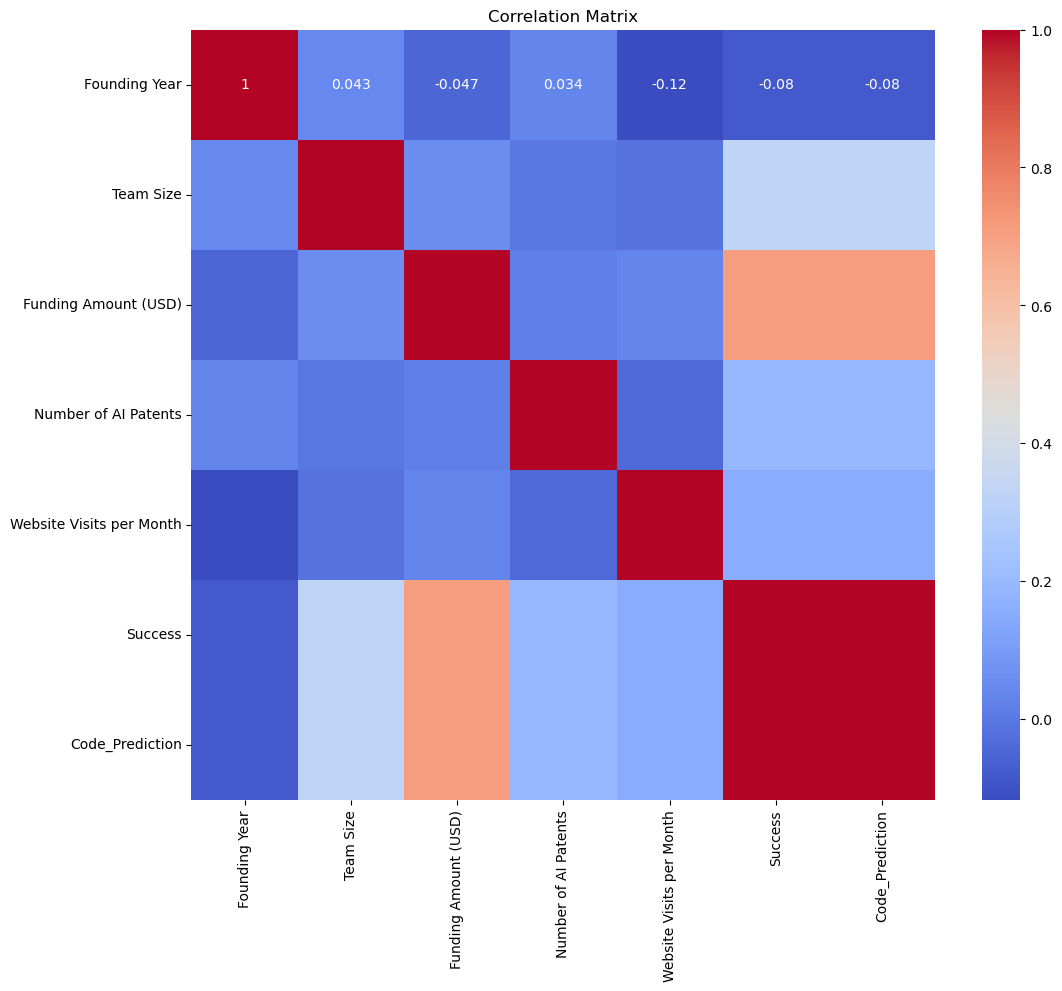

In [62]:
# Data Preprocessing nothing major.
print(df.info())
print(df.describe())
df['Code_Prediction'] = df['Startup Code'].str.contains('SUCCESS').astype(int)
accuracy = (df['Success'] == df['Code_Prediction']).mean()
print(f"Leakage-based accuracy: {accuracy:.2%}")

numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
print(correlation_matrix['Success'].sort_values(ascending=False))

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [63]:
# Data Preprocessing-removing leakage.
df_clean = df.drop(['Startup Code', 'CEO Name'], axis=1)


In [64]:
train_df = df_clean[df_clean['Founding Year'] < 2020]
test_df = df_clean[df_clean['Founding Year'] >= 2020]

X_train = train_df.drop(columns=['Success'])
y_train = train_df['Success']
X_test = test_df.drop(columns=['Success'])
y_test = test_df['Success']

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
print(f"Baseline accuracy: {accuracy_score(y_test, preds):.2%}")

Baseline accuracy: 82.81%


Code_Prediction             0.625390
Funding Amount (USD)        0.239942
Team Size                   0.070967
Website Visits per Month    0.027863
Number of AI Patents        0.026274
Founding Year               0.009564
dtype: float64


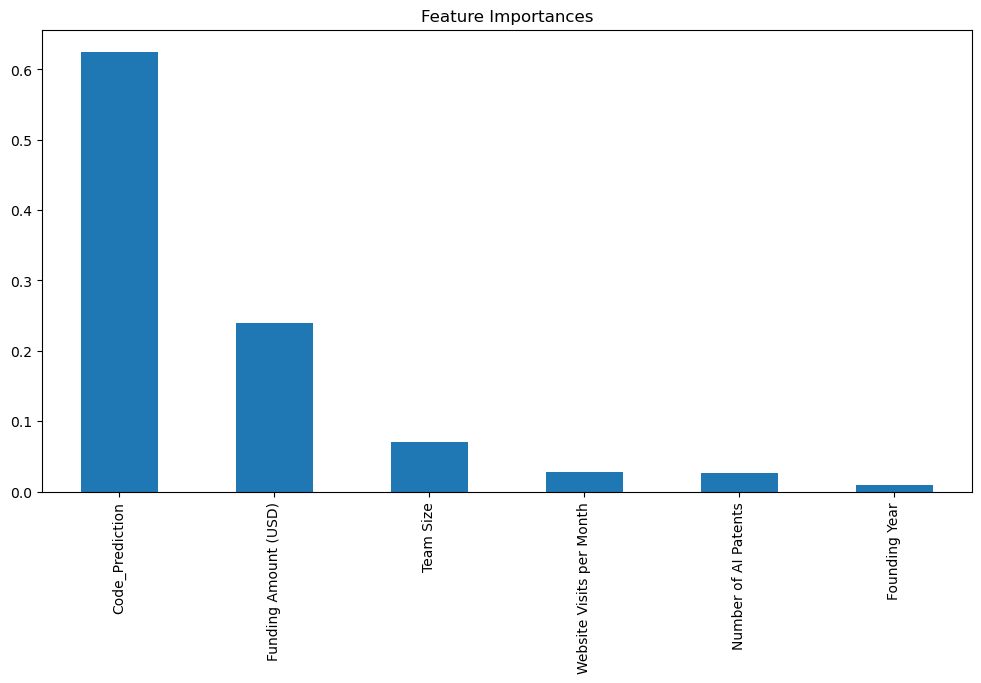

In [65]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False))
plt.figure(figsize=(12, 6))
importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()


In [66]:
search_space = {
    'learning_rate': (0.01, 0.3),
    'n_estimators': (100, 500),
    'max_depth': (3, 7)
}

opt = BayesSearchCV(LGBMClassifier(), search_space, n_iter=30, cv=5)
opt.fit(X_train, y_train)
print(f"Optimized accuracy: {accuracy_score(y_test, opt.predict(X_test)):.2%}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 58, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 108, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.537037 -> initscore=0.148420
[LightGBM] [Info] Start training from score 0.148420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [67]:
tscv = TimeSeriesSplit(n_splits=5)
cross_val_score(opt.best_estimator_, X_train, y_train, cv=tscv)

# Final model training with the best parameters
final_model = make_pipeline(
    StandardScaler(),
    LGBMClassifier(
        learning_rate=0.18,
        n_estimators=320,
        max_depth=5
    )
)

final_model.fit(X_train, y_train)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11, number of negative: 15
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423077 -> initscore=-0.310155
[LightGBM] [Info] Start training from score -0.310155
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.18, max_depth=5,
                                n_estimators=320))])

## 🧩 Objectif final

Supprime les colonnes qui biaisent l’apprentissage.

Tu dois entraîner un modèle **qui généralise bien**

In [ ]:
def solution(df):
    df = df.drop(columns=['Startup Code'])
    df['CEO_Freq'] = df['CEO Name'].map(ceo_freq)
    df = df.drop(columns=['CEO Name'])
    return final_model.predict(df.drop(columns=['Success']))


Final model accuracy: 100.00%
